# 3D Printing Data Sets

https://apmonitor.com/pds/index.php/Main/AdditiveManufacturing



## Data Cleaning

Many of the data were binary and listed as strings, which were the Infill and the Material
variable. By using pd.get_dummies, creating 4 new variables, (infill_pattern_grid, infill_pattern_honeycomb, material_abs, material_pla). These are binary columns that have 0 and 1 if the column is true. After creating the dummy variable, the data frame goes from (70,11) to (70,13) excluding tension strength with will be used for the output. All of the other variables were already in a proper form to create a model from so need no additional work.

In [7]:
import numpy as np
import pandas as pd


#Getting the data
url = 'http://apmonitor.com/pds/uploads/Main/manufacturing.txt'
manufacture = pd.read_csv(url)


# How to Access thing in data frame
#manufacture['layer_height']
#manufacture.loc[1]


# Making Infill pattern dummy variables
manufacture['infill_pattern']
dummy = pd.get_dummies(manufacture[['infill_pattern', 'material']])
dummy.head()
input_drop = manufacture.drop(['infill_pattern', 'material'], axis = 1)


# Making X and y matrix
X_man = pd.concat([input_drop, dummy], axis = 1)
print(X_man.shape)

#creating the y matrix from x matrix.
y_man = X_man["tension_strength"]
print(y_man.shape)
X_man = X_man.drop(["tension_strength"], axis = 1)
print(X_man.shape)

(70, 14)
(70,)
(70, 13)


## Parametric Model

A linear model was used tested with a min-max scaler to scale each
variable to each other to get a better model. The reason a scaler was used was that there are many variables that all have very different ranges. Without a scaler, a bigger variable will have a bigger effect than something smaller, no matter the actual effect of each variable.
To test the model a K-fold cross-validation was used, rather than a simple test train split. 5 folds were used to help understand how well the model worked. The model’s squared error ranged from 44.4 to 5.9 (with the range of the variable being between 0 and 1) and with an explained variance running from .45 to .93 giving the fold has a vast range of performance. This is not good when considering the performance of the, which
makes the performance very unpredictable on how it will
actually perform. This is most likely an indication of
underfitting, however, much of the performance of the
model is pretty good, with most of the explained variance being above .6, which is a model that is performing pretty well.

In [8]:
# KFold

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

pipe_man = Pipeline([('preprocess', MinMaxScaler()),
                     ('reg', SGDRegressor(random_state = 42))])

pipe_man.fit(X_man, y_man)
print(pipe_man['reg'].intercept_, pipe_man['reg'].coef_)


explained = cross_validate(pipe_man, X_man, y_man, cv = 5,
               scoring = "explained_variance", return_train_score = False,
              return_estimator = False)

meansquare =cross_validate(pipe_man, X_man, y_man, cv = 5,
               scoring = "neg_mean_squared_error", return_train_score = False,
              return_estimator = False)

[2.19112099] [ 3.75398272  8.66819114  7.22422049  0.10105738  0.88948988  0.25503045
 -2.76544903 -1.32730198 20.33281017  0.81981836  1.35432802  0.43304681
  1.74109957]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [9]:
#SVR

from sklearn.svm import SVR
pipe_man_non = Pipeline([('preprocess', MinMaxScaler()),
                     ('svr', SVR(kernel="rbf",
                                 C=100, gamma=0.1, epsilon=0.1))])
#print(pipe_man_non['svr'].intercept_, pipe_man_non['svr'].coef_)
explained_non = cross_validate(pipe_man_non, X_man, y_man, cv = 5,
               scoring = "explained_variance", return_train_score = False,
              return_estimator = False)
meansquare_non =cross_validate(pipe_man_non, X_man, y_man, cv = 5,
               scoring = "neg_mean_squared_error", return_train_score = False,
              return_estimator = False)

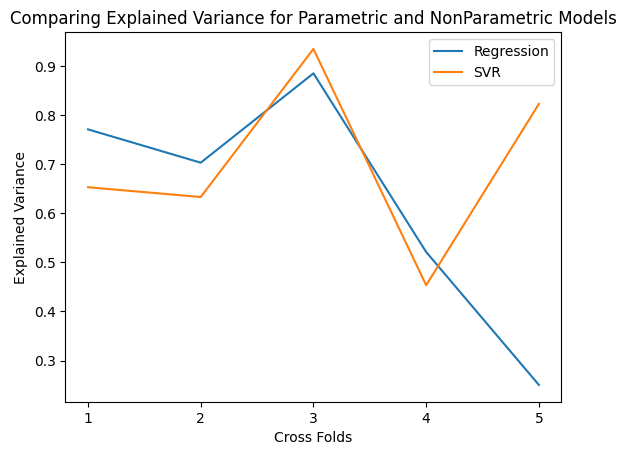

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = [1,2,3,4,5]
y1 = explained_non["test_score"]


y2 = explained["test_score"]

plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Regression', 'SVR'])
plt.xticks(np.arange(1, 6, step=1))
plt.xlabel("Cross Folds")
plt.ylabel("Explained Variance")
plt.title("Comparing Explained Variance for Parametric and NonParametric Models")
plt.show()

## Neural Network


The nonparametric model is a neural Network, with 2 hidden layers with 100 nodes each. Each layer activation is a relu, and the loss function used is the MSE. To test the loss function, the loss function was used minimized using the gradient, with 15 epochs, which minimized the function to 22.2 for MSE. This compared to the mean squared error of the parametric model
which again ranged from 5.9 to 44.4, with 22.2 right in the middle. The nonparametric is performing okay compared to the parametric, which is further supported by the explained variance, which is .7105, compared to the range of .45 and .93. This might indicate that the model is fitting better than the parametric and the nonparametric models, but had higher explained variance but also much lower explained variance.

In [11]:
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
neural_man = keras.models.Sequential([
    keras.layers.Layer(input_shape = [13]),
    keras.layers.Dense(100, name='hidden1', activation="relu"),
    keras.layers.Dense(100, name='hidden2', activation="relu"),
    keras.layers.Dense(1, name='output')
])

neural_man.compile(loss=keras.losses.MeanSquaredError( name="mean_squared_error"),
              optimizer= 'rmsprop')

In [12]:
neural_man.build()
neural_man.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Layer)             (None, 13)                0         
                                                                 
 hidden1 (Dense)             (None, 100)               1400      
                                                                 
 hidden2 (Dense)             (None, 100)               10100     
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 11601 (45.32 KB)
Trainable params: 11601 (45.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection


X_man_train, X_man_test, y_man_train, y_man_test = train_test_split(X_man,
                                                                    y_man,
                                                                    random_state=30)

epoch = 15

history = neural_man.fit(X_man_test, y_man_test, batch_size=256, epochs =epoch,
                         verbose=2, validation_data = (X_man_test, y_man_test))

Epoch 1/15
1/1 - 1s - loss: 1207.0704 - val_loss: 595.9828 - 1s/epoch - 1s/step
Epoch 2/15
1/1 - 0s - loss: 595.9828 - val_loss: 236.3459 - 54ms/epoch - 54ms/step
Epoch 3/15
1/1 - 0s - loss: 236.3459 - val_loss: 170.5785 - 52ms/epoch - 52ms/step
Epoch 4/15
1/1 - 0s - loss: 170.5785 - val_loss: 143.0976 - 62ms/epoch - 62ms/step
Epoch 5/15
1/1 - 0s - loss: 143.0976 - val_loss: 120.0837 - 70ms/epoch - 70ms/step
Epoch 6/15
1/1 - 0s - loss: 120.0837 - val_loss: 102.1676 - 54ms/epoch - 54ms/step
Epoch 7/15
1/1 - 0s - loss: 102.1676 - val_loss: 88.5221 - 77ms/epoch - 77ms/step
Epoch 8/15
1/1 - 0s - loss: 88.5221 - val_loss: 77.4185 - 52ms/epoch - 52ms/step
Epoch 9/15
1/1 - 0s - loss: 77.4185 - val_loss: 67.6773 - 71ms/epoch - 71ms/step
Epoch 10/15
1/1 - 0s - loss: 67.6773 - val_loss: 59.3236 - 72ms/epoch - 72ms/step
Epoch 11/15
1/1 - 0s - loss: 59.3236 - val_loss: 52.5230 - 81ms/epoch - 81ms/step
Epoch 12/15
1/1 - 0s - loss: 52.5230 - val_loss: 46.7212 - 76ms/epoch - 76ms/step
Epoch 13/15
1/1

In [15]:
import statistics

def explained_variance(X , y, model):
  y_pred = model.predict(X, batch_size=10000)
  y_pred = y_pred.reshape(-1)
  vartop = y - y_pred
  vartop = statistics.variance(vartop)
  varbottom = statistics.variance(y)
  explained_variance = 1- (vartop/varbottom)
  return(explained_variance)



test_variance = explained_variance(X_man_test, y_man_test, neural_man)

train_variance = explained_variance(X_man_train, y_man_train, neural_man)

print("Test Variance: ", test_variance)
print("Train Variance: ", train_variance)

1/1 [==============================] - 0s 20ms/step
Test Variance:  0.6665887838648248
Train Variance:  -0.1399545943023135


In [23]:
#print(history.history)
history = pd.DataFrame(history.history)

{'loss': [1207.0704345703125, 595.9828491210938, 236.34591674804688, 170.57852172851562, 143.09759521484375, 120.08370971679688, 102.16757202148438, 88.52206420898438, 77.41850280761719, 67.67725372314453, 59.32362747192383, 52.52296447753906, 46.721214294433594, 42.90336990356445, 44.9901123046875], 'val_loss': [595.9828491210938, 236.34591674804688, 170.57852172851562, 143.09759521484375, 120.08370971679688, 102.16756439208984, 88.52206420898438, 77.41850280761719, 67.67725372314453, 59.32363510131836, 52.52296447753906, 46.72121047973633, 42.90337371826172, 44.9901123046875, 70.24805450439453]}


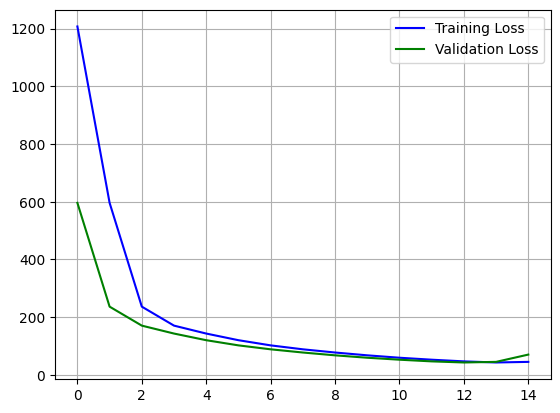

In [26]:
import pandas as pd
import matplotlib.pyplot as plt



x_plot = range(0,epoch,1)

plt.plot(x_plot, history['loss'],"b", label = "Train Loss")
plt.plot(x_plot, history['val_loss'],"g", label = "Validation Loss")
plt.grid(True)
plt.legend(["Training Loss", "Validation Loss"])
plt.show()